In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [62]:
# load all salary data
all_salaries = pd.read_csv("https://www.dropbox.com/scl/fi/zi64gecfq5tj98wypf0bu/all_salaries.csv?rlkey=nal9utxtoyoky6skqejgnr57h&dl=1")

In [65]:
print(all_salaries.isna().sum())

Name             0
Title           23
Organization     0
Salary           0
Fiscal Year      0
dtype: int64


In [66]:
print(len(all_salaries[all_salaries['Salary'] < 0]))

1472


In [67]:
all_salaries = all_salaries.dropna()
all_salaries = all_salaries[all_salaries['Salary'] > 0]

In [6]:
# analytics code (stuff that might go in a notebook)
# median salaries by org, year
salary_groupby_df = all_salaries[['Salary', 'Organization', 'Fiscal Year']].\
                        groupby(["Organization", "Fiscal Year"], as_index=False).\
                        median().\
                        sort_values(by=['Organization', 'Fiscal Year'])

# max and median salary and corresponding year, by org
max_salary_year_by_org = salary_groupby_df.groupby(["Organization"], as_index=False).max()
min_salary_year_by_org = salary_groupby_df.groupby(["Organization"], as_index=False).min()

# merge dfs to get max and min median salary on one row per org
salary_difference_by_org = max_salary_year_by_org.merge(min_salary_year_by_org,
                                                        on='Organization',
                                                        how='inner',
                                                        suffixes=('_max', '_min'))

# calculated column to get percent difference in median salary between max and min years
salary_difference_by_org['Percent Change'] = 100 * \
                                             (salary_difference_by_org['Salary_max'] / salary_difference_by_org['Salary_min']) \
                                             - 100

# two different ways to filter nan and inf
#  1. where not (inf or nan)
salary_difference_by_org = salary_difference_by_org[~ (np.isinf(salary_difference_by_org['Percent Change']) | np.isnan(salary_difference_by_org['Percent Change']))]
#  2. where finite
salary_difference_by_org = salary_difference_by_org[np.isfinite(salary_difference_by_org['Percent Change'])]

# filter out rows where max and min year are the same (i.e. org only appeared in one year)
#  (i.e filter rows where percent change = 0
salary_difference_by_org = salary_difference_by_org[salary_difference_by_org['Percent Change'] != 0]

# need to do another groupby to get count of salaries by (org, year),
#  then join that to the difference df to get more context on percent changes
# there should be two joins so we can get count in max AND min years
# maybe we can filter out orgs with a salary count below a certain threshold
salary_counts = all_salaries[['Salary', 'Organization', 'Fiscal Year']].\
                        groupby(["Organization", "Fiscal Year"], as_index=False).\
                        count().\
                        rename(columns={'Salary': "Salary Count"})

# merge counts twice with the df that has percent differences to get count in min and max years
salary_difference_by_org = salary_difference_by_org.merge(salary_counts,
                                                          left_on=['Organization', 'Fiscal Year_min'],
                                                          right_on=['Organization', 'Fiscal Year'],
                                                          how='left')\
                                                    .rename(columns={'Salary Count': 'Salary Count_min'})

salary_difference_by_org = salary_difference_by_org.merge(salary_counts,
                                                          left_on=['Organization', 'Fiscal Year_max'],
                                                          right_on=['Organization', 'Fiscal Year'],
                                                          how='left')\
                                                    .rename(columns={'Salary Count': 'Salary Count_max'})\
                                                    .drop(columns=['Fiscal Year_x', 'Fiscal Year_y'])

In [13]:
(salary_difference_by_org[(salary_difference_by_org['Salary Count_min'] > 100) & (salary_difference_by_org['Salary Count_max'] > 100)]
                         .sort_values(by='Percent Change', ascending=False)).head(20)

,Organization,Fiscal Year_max,Salary_max,Fiscal Year_min,Salary_min,Percent Change,Salary Count_min,Salary Count_max
113,"Defense, Department Of",2022,24544.940,2013,620.380,3856.436378,694,1005
7,"Agricultural Exposition Authority, Georgia",2022,8509.900,2013,976.880,771.130538,275,271
282,Secretary Of State,2022,33713.780,2013,6707.500,402.628103,680,534
123,East Georgia State College,2022,30545.150,2013,8867.720,244.453253,409,291
265,"Public Telecommunications Commission, Georgia",2022,48510.000,2013,14602.100,232.212490,175,312
143,Fort Valley State University,2022,24669.210,2013,7926.270,211.233531,1449,1045
277,Savannah State University,2022,23619.070,2013,7656.250,208.493976,1338,837
252,Pickens County Board Of Education,2022,49612.970,2013,16412.610,202.285682,855,686
23,Augusta Technical College,2022,26904.010,2013,8981.070,199.563526,642,483
351,"World Congress Center Authority, Geo L Smith I...",2022,10910.000,2013,3676.420,196.756083,1839,561


In [69]:
all_salaries[all_salaries['Title'].str.contains('teacher', case=False, regex=False)][['Salary', 'Fiscal Year']].groupby('Fiscal Year').median()

,Salary
Fiscal Year,
2013,41617.115
2014,41948.500
2015,41398.955
2016,42440.380
2017,43377.500
2018,42985.450
2019,45229.740
2020,48127.250
2021,53275.055


(array([1.309295e+06, 1.212290e+05, 2.600000e+01, 1.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([1.00000000e-02, 7.30191770e+04, 1.46038344e+05, 2.19057511e+05,
        2.92076678e+05, 3.65095845e+05, 4.38115012e+05, 5.11134179e+05,
        5.84153346e+05, 6.57172513e+05, 7.30191680e+05]),
 <BarContainer object of 10 artists>)

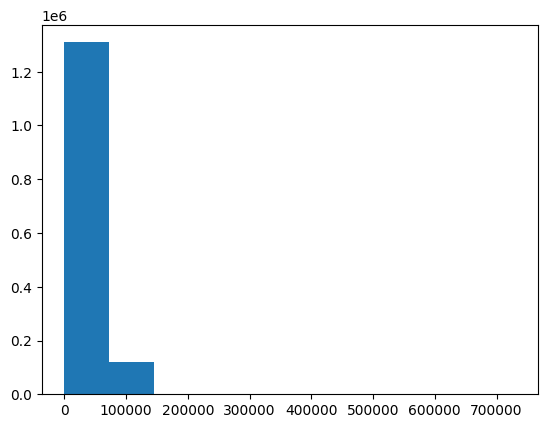

In [86]:
plt.hist(all_salaries[all_salaries['Title'].str.contains('teacher', case=False, regex=False)]['Salary'])

In [88]:
all_salaries[all_salaries['Title'].str.contains('teacher', case=False, regex=False)]['Salary'].max()

730191.68

# 2018 is messed up!